In [ ]:
from google.colab import files

files.upload()

!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c forest-cover-type-prediction
!unzip forest-cover-type-prediction.zip

 91% 23.0M/25.3M [00:00<00:00, 53.0MB/s]
100% 25.3M/25.3M [00:00<00:00, 51.3MB/s]
Archive:  forest-cover-type-prediction.zip
  inflating: sampleSubmission.csv    
  inflating: sampleSubmission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: test3.csv               
  inflating: train.csv               
  inflating: train.csv.zip           


# Imports

In [ ]:
import warnings
from copy import deepcopy
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.svm import SVC

pd.set_option('display.max_columns', None)

# Constants

In [ ]:
RANDOM_STATE = 13
N_CLASS = 7  # number of Cover_Type class
TEST_SIZE = 0.2

# Load Dataset

In [ ]:
df = pd.read_csv("train.csv", index_col="Id")
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 1 to 15120
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           15120 non-null  int64
 1   Aspect                              15120 non-null  int64
 2   Slope                               15120 non-null  int64
 3   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 4   Vertical_Distance_To_Hydrology      15120 non-null  int64
 5   Horizontal_Distance_To_Roadways     15120 non-null  int64
 6   Hillshade_9am                       15120 non-null  int64
 7   Hillshade_Noon                      15120 non-null  int64
 8   Hillshade_3pm                       15120 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 10  Wilderness_Area1                    15120 non-null  int64
 11  Wilderness_Area2                    15120 non-null  int64
 12  Wild

In [ ]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.00000

In [ ]:
df.isna().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


## Conversion negative/positive values to positive

In [ ]:
df['Vertical_Distance_To_Hydrology'] += abs(df["Vertical_Distance_To_Hydrology"].min())

# Plots

## Correlation of columns

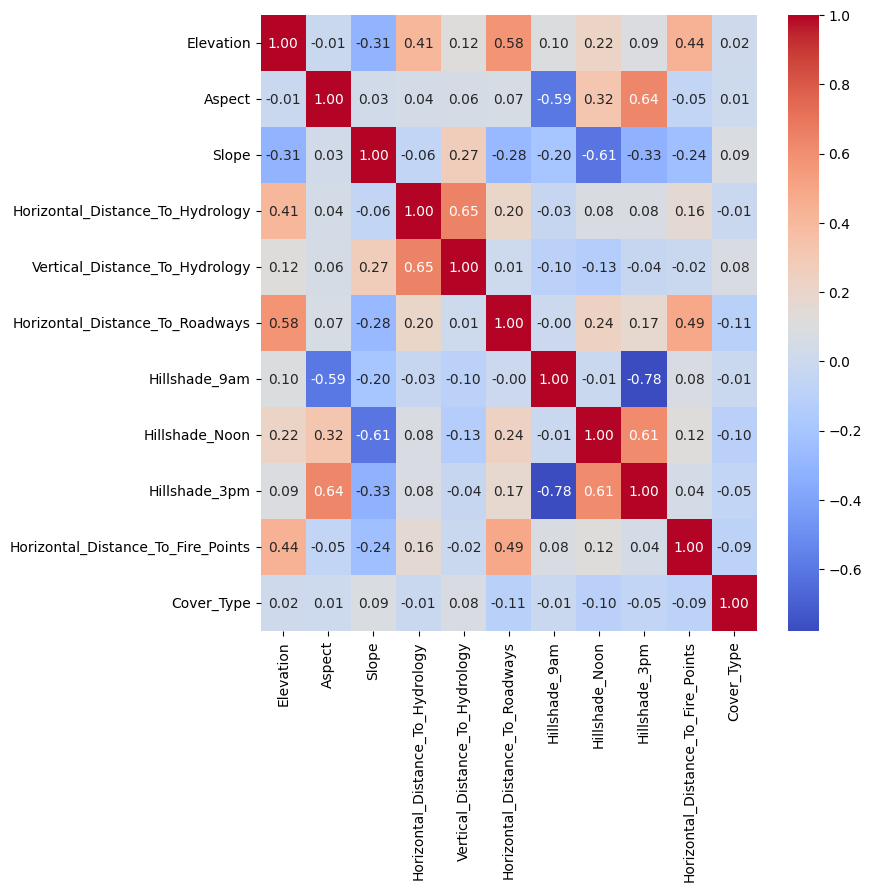

In [ ]:
corr = pd.concat([df.iloc[:,:10], df["Cover_Type"]], axis=1).corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Scatter plots

In [ ]:
def plot_scatter(df, x, y):
    plt.figure(figsize=(15,6))
    sns.scatterplot(data=df, x=x, y=y, hue='Cover_Type', palette="tab10")
    plt.legend()
    plt.show()

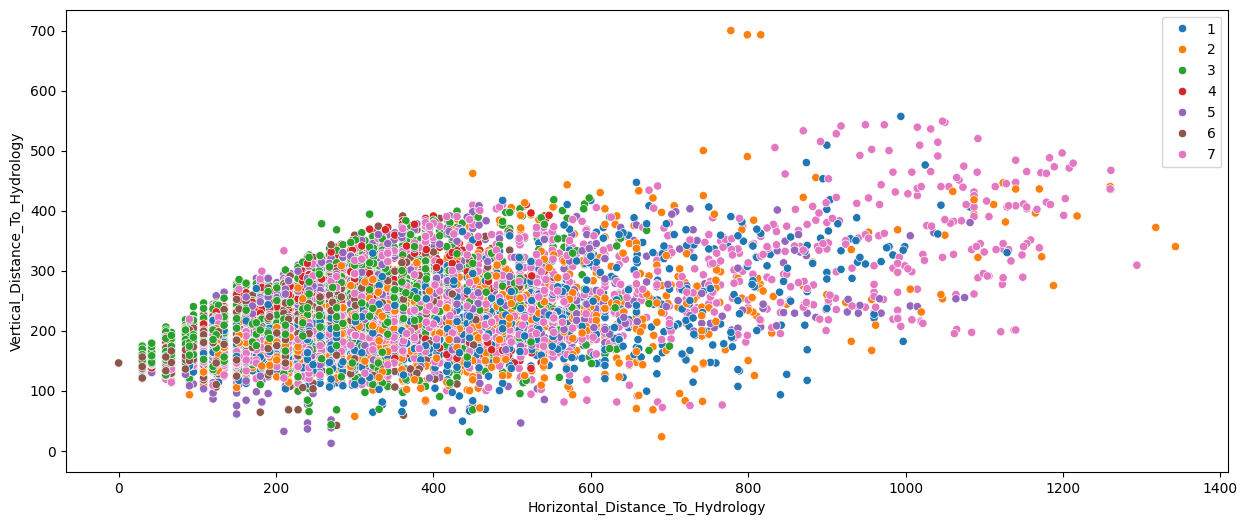

In [ ]:
plot_scatter(df, 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology')

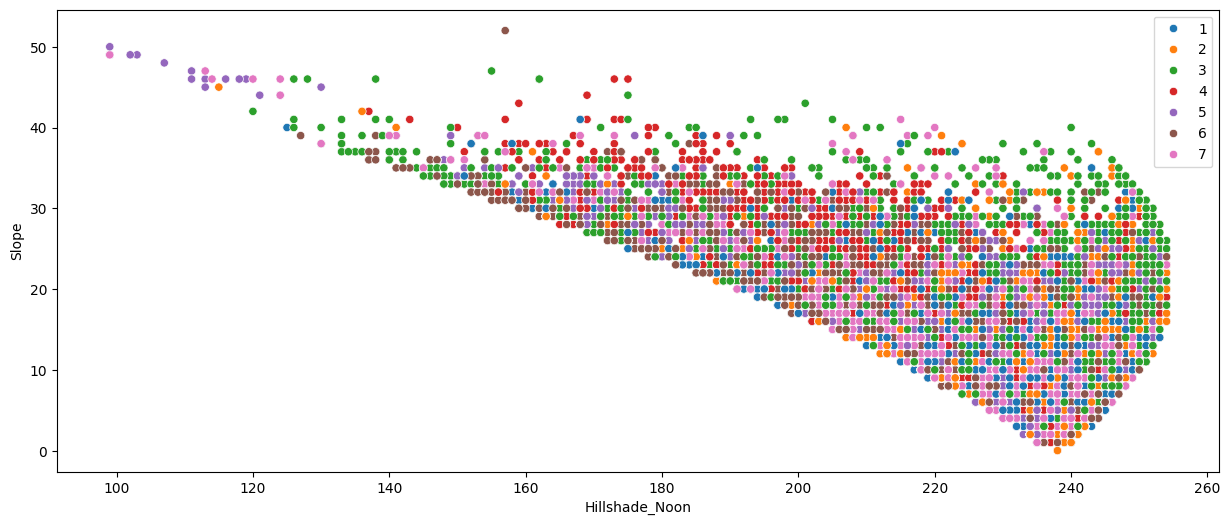

In [ ]:
plot_scatter(df, 'Hillshade_Noon', 'Slope')

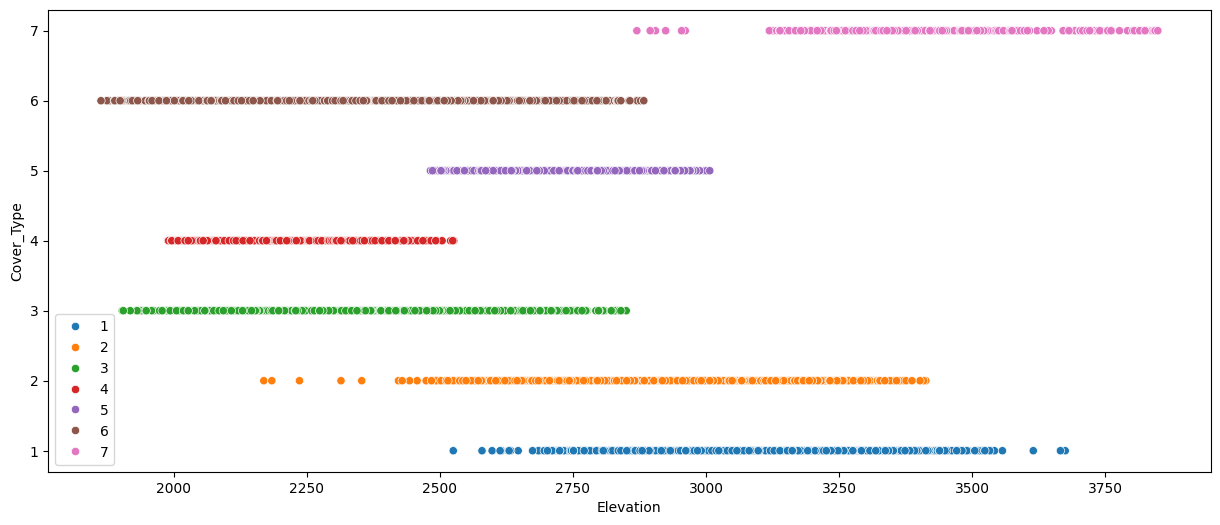

In [ ]:
plot_scatter(df, 'Elevation', 'Cover_Type')

## Count plots for "Cover Type"

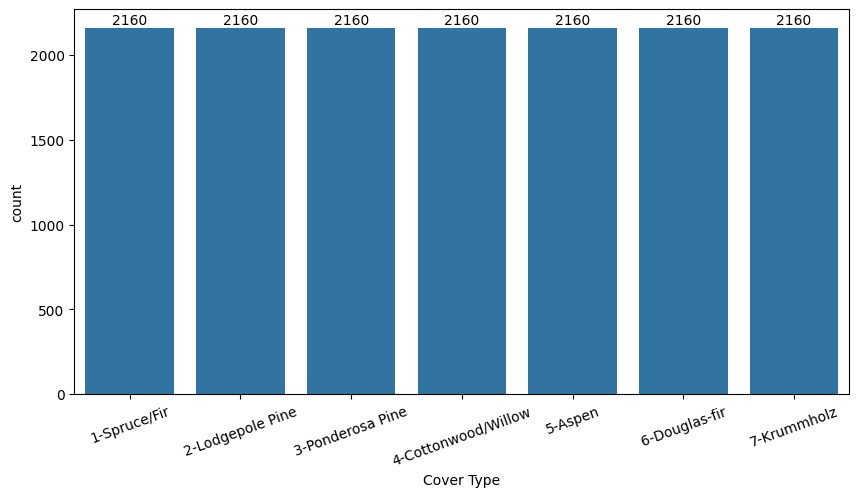

In [ ]:
keys = {
    "1": "1-Spruce/Fir",
    "2": "2-Lodgepole Pine",
    "3": "3-Ponderosa Pine",
    "4": "4-Cottonwood/Willow",
    "5": "5-Aspen",
    "6": "6-Douglas-fir",
    "7": "7-Krummholz"
}

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Cover_Type', data=df)
ax.bar_label(ax.containers[0], label_type='edge')
plt.xticks(list(keys.keys()), list(keys.values()))
plt.xticks(rotation=20)
plt.xlabel("Cover Type")
plt.show()

## Relation Scatter Types and Soil Types

In [ ]:
soil_types = df[[
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4',
       'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']]

soil_types = soil_types.groupby("Cover_Type").sum()
soil_types = soil_types.to_numpy()

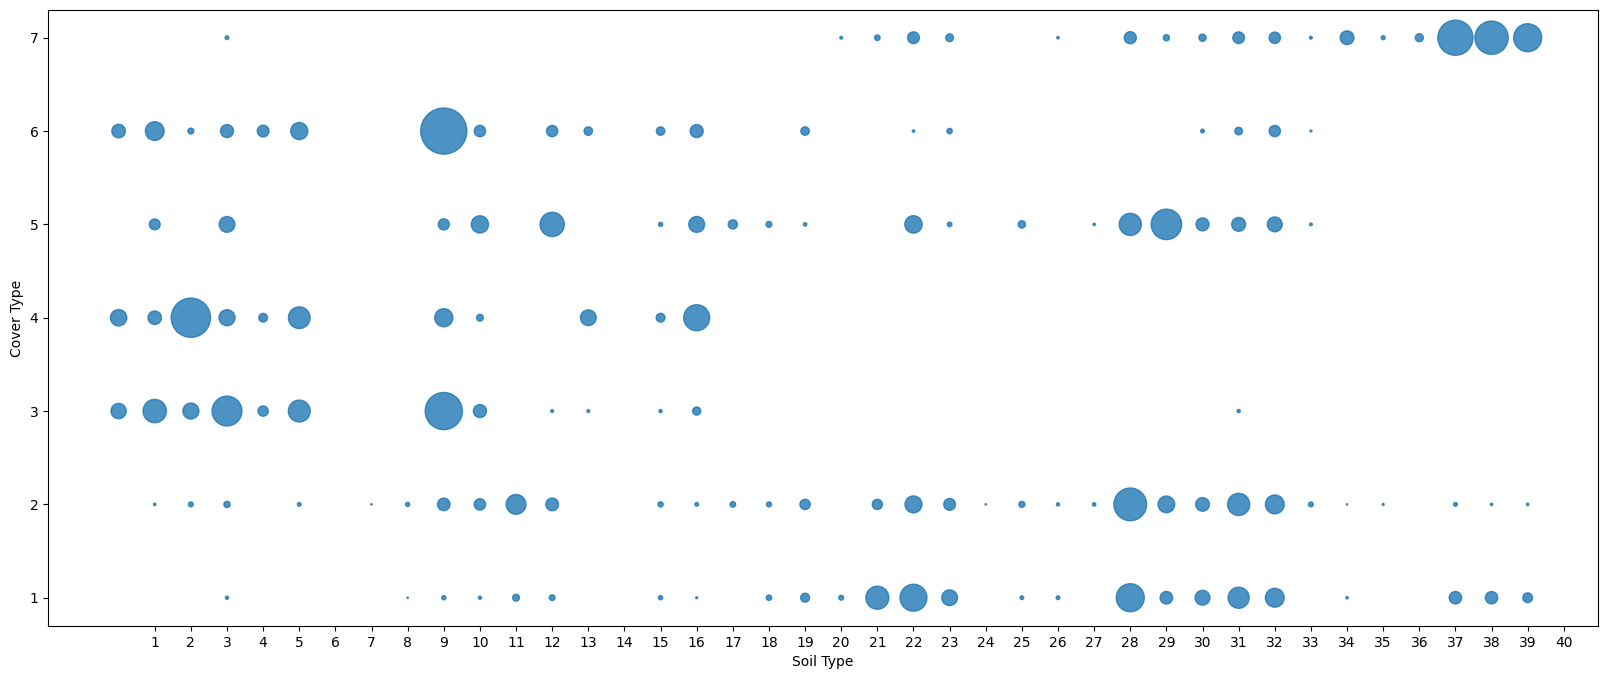

In [ ]:
plt.figure(figsize=(20, 8))
x = np.arange(soil_types.shape[1])
y = np.arange(soil_types.shape[0])
x, y = np.meshgrid(x, y) # get the coordinates of the grid
size = soil_types.ravel() # get the size values of the grid

# Plot the scatter plot
plt.scatter(x, y + 1, s=size, alpha=0.8, label='Size')
plt.xticks(list(range(1, 41)))
plt.yticks(list(range(1, 8)))
plt.ylabel("Cover Type")
plt.xlabel("Soil Type")
plt.show()

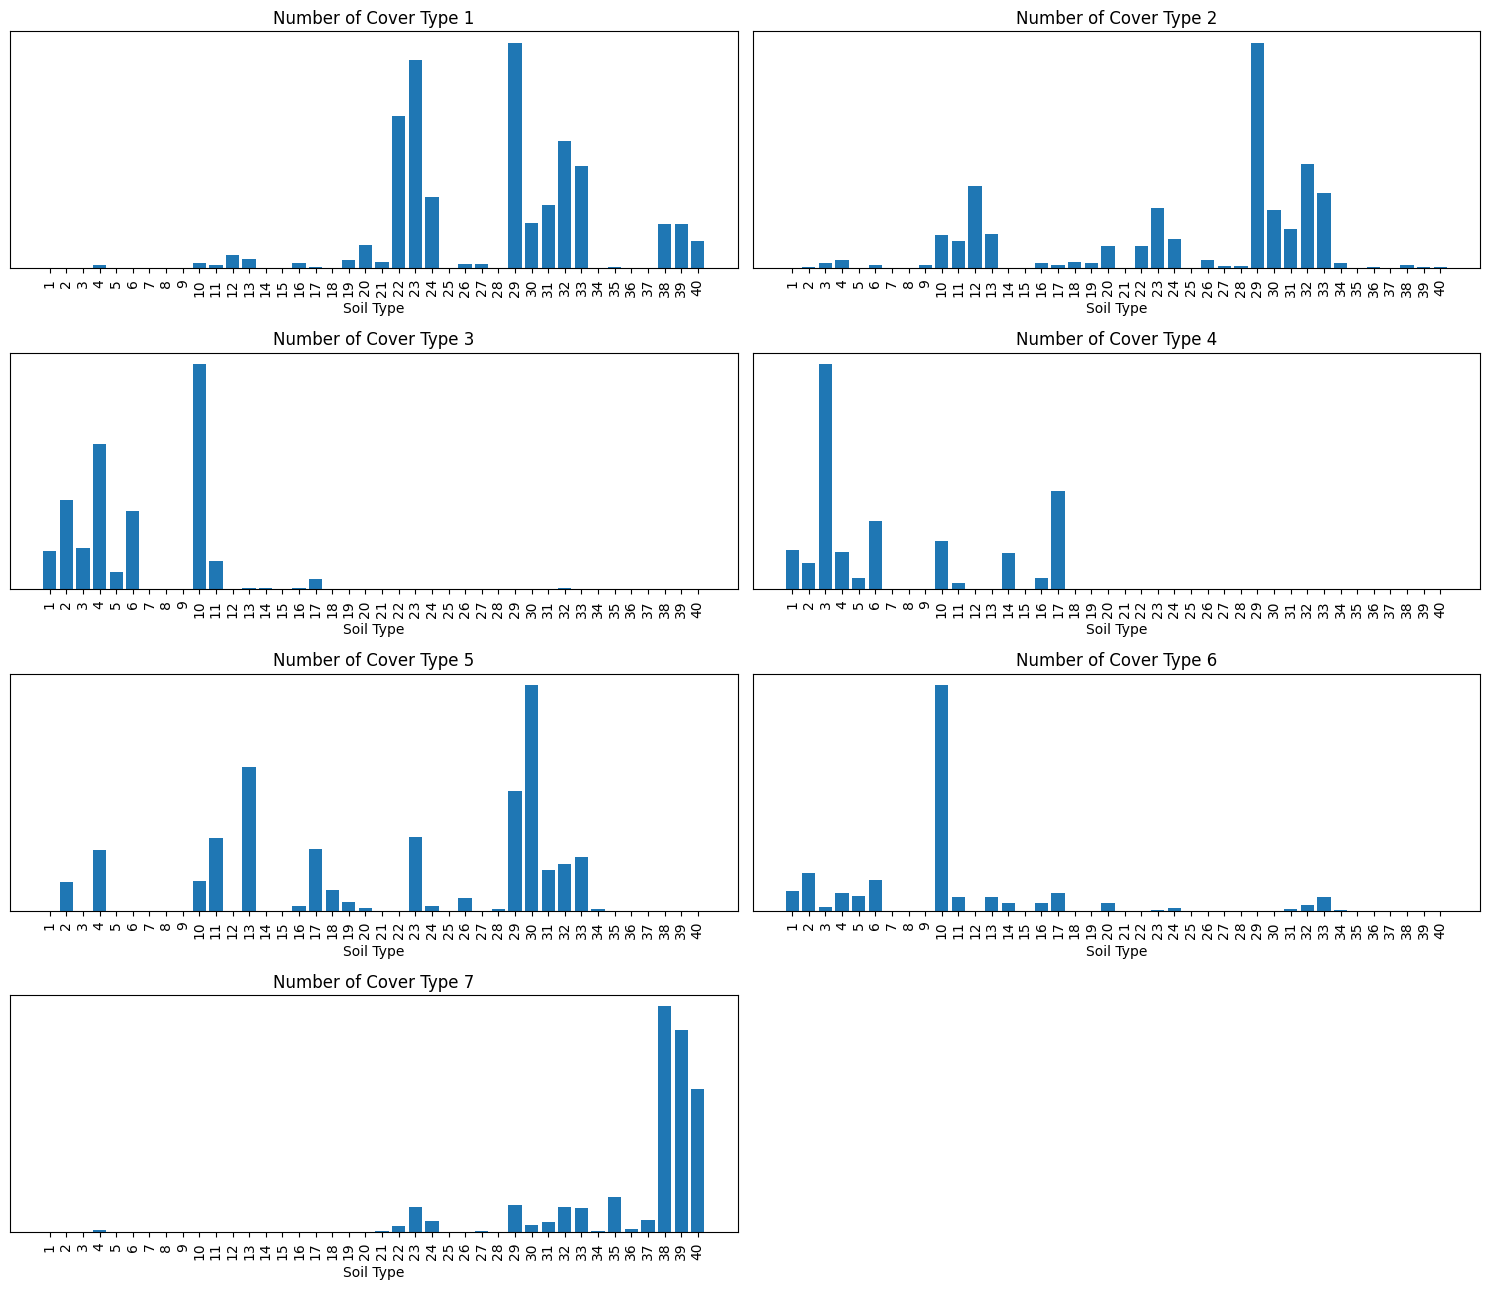

In [ ]:
plt.figure(figsize = (15,13))
for i in range(7):
    plt.subplot(4, 2, i+1)
    plt.bar(np.arange(1, 41, 1), soil_types[i,:])
    plt.xticks(np.arange(1, 41, 1))
    plt.xlabel("Soil Type")
    plt.yticks([])
    plt.xticks(rotation=90)
    plt.title(f"Number of Cover Type {i+1}")
plt.tight_layout()

# Models

## get and split data

In [ ]:
x_train = df.drop(["Cover_Type"], axis=1)
y_train = df["Cover_Type"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"number of train data: {len(x_train)}")
print(f"number of train data: {len(x_test)}")

number of train data: 12096
number of train data: 3024


## PCA

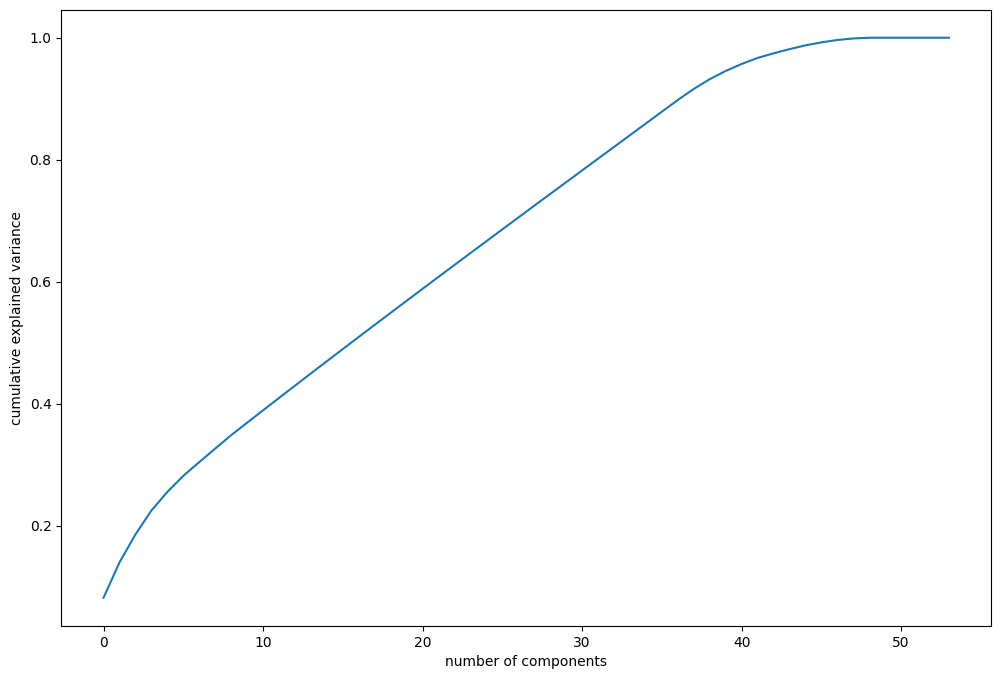

In [ ]:
pca = PCA(svd_solver='randomized', random_state=RANDOM_STATE)
pca.fit(scale(x_train))

fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## Evaluation Function

In [ ]:
def eval_model(model, x_train, y_train, x_test, y_test, model_name):
    start_time = datetime.now()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    end_time = datetime.now()

    model_eval = pd.DataFrame({'Accuracy': [accuracy_score(y_test, y_predict)],
                                'Precision': [precision_score(y_test, y_predict, average='weighted')],
                                'Recall': [recall_score(y_test, y_predict, average='weighted')],
                                'F1 Score': [f1_score(y_test, y_predict, average='weighted')],
                                'Time (second)': [(end_time - start_time).total_seconds()]},
                              index=[model_name])
    return model_eval

## Define models

In [ ]:
def get_pipe(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        # ('PCA', IncrementalPCA(n_components=48)),  NOTE: Not helpful
        ('model', model)
    ])

In [ ]:
evaluation_rf = pd.DataFrame()

for i in range(1, 100):
    model = RandomForestClassifier(max_features='sqrt', n_estimators=200, random_state=RANDOM_STATE, max_depth=i)
    evaluation_rf = pd.concat([evaluation_rf , eval_model(get_pipe(model), x_train, y_train, x_test, y_test, f"Random Forest with depth {i}")])

In [ ]:
evaluation_rf.sort_values(["Accuracy"],  ascending=False).head(20)

,Accuracy,Precision,Recall,F1 Score,Time (second)
Random Forest with depth 32,0.864418,0.861966,0.864418,0.862323,14.348842
Random Forest with depth 25,0.862434,0.860407,0.862434,0.860319,5.759280
Random Forest with depth 33,0.861772,0.859411,0.861772,0.859764,5.472556
Random Forest with depth 29,0.859788,0.857357,0.859788,0.857632,5.759878
Random Forest with depth 39,0.859458,0.857203,0.859458,0.857579,5.884034
Random Forest with depth 27,0.859458,0.857157,0.859458,0.857230,5.790315
Random Forest with depth 41,0.859458,0.857293,0.859458,0.857613,5.330627
Random Forest with depth 38,0.859127,0.856980,0.859127,0.857307,5.133226
Random Forest with depth 24,0.859127,0.856739,0.859127,0.856850,5.023076
Random Forest with depth 26,0.858796,0.856395,0.858796,0.856612,5.707028


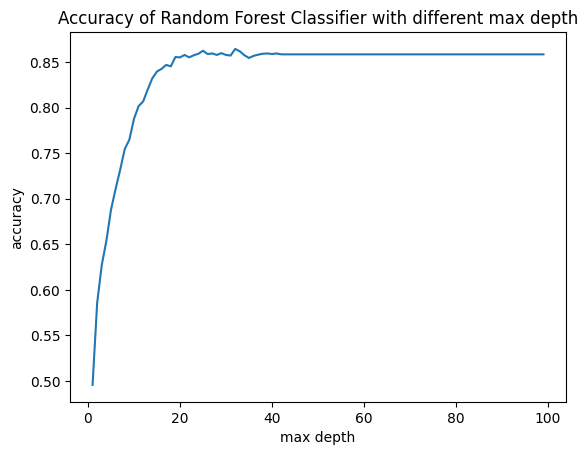

In [ ]:
plt.plot(evaluation_rf.index.map(lambda x : int(x.split()[-1])), evaluation_rf.Accuracy)
plt.title("Accuracy of Random Forest Classifier with different max depth")
plt.ylabel("accuracy")
plt.xlabel("max depth")
plt.show()

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE),
    "SVC": SVC(C=N_CLASS, kernel="rbf", probability=False, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=1),
    "Random Forest Classifier": RandomForestClassifier(max_features='sqrt', n_estimators=200, random_state=RANDOM_STATE, max_depth=25),
    "Gaussian Naive Bayes": GaussianNB(),
    "One Layer ReLU MLP (lr=0.001)": MLPClassifier(hidden_layer_sizes=(128,), activation='relu', learning_rate_init=0.001, learning_rate="adaptive", solver="adam"),
    "One Layer ReLU MLP (lr=0.1)": MLPClassifier(hidden_layer_sizes=(128,), activation='relu', learning_rate_init=0.1, learning_rate="adaptive", solver="adam"),
    "Three Layer ReLU MLP (lr=0.001)": MLPClassifier(hidden_layer_sizes=(128,128,128), activation='relu', learning_rate_init=0.001, learning_rate="adaptive", solver="adam"),
    "Three Layer ReLU MLP (lr=0.1)": MLPClassifier(hidden_layer_sizes=(128,128,128), activation='relu', learning_rate_init=0.1, learning_rate="adaptive", solver="adam"),
}

## Evaluate

In [ ]:
evaluation = pd.DataFrame()

for index, (model_name, model) in enumerate(models.items()):
    evaluation = pd.concat([evaluation , eval_model(get_pipe(model), x_train, y_train, x_test, y_test, model_name)])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
evaluation

,Accuracy,Precision,Recall,F1 Score,Time (second)
Logistic Regression,0.697421,0.693828,0.697421,0.693272,9.850834
SVC,0.786706,0.783452,0.786706,0.783541,5.886041
KNN,0.812500,0.809901,0.812500,0.809792,0.406432
Random Forest Classifier,0.862434,0.860407,0.862434,0.860319,5.513182
Gaussian Naive Bayes,0.461310,0.453040,0.461310,0.374282,0.050201
One Layer ReLU MLP (lr=0.001),0.824074,0.822993,0.824074,0.822693,26.618555
One Layer ReLU MLP (lr=0.1),0.736111,0.744949,0.736111,0.732150,4.538548
Three Layer ReLU MLP (lr=0.001),0.850860,0.852768,0.850860,0.849467,68.468293
Three Layer ReLU MLP (lr=0.1),0.295635,0.089145,0.295635,0.136666,8.780303


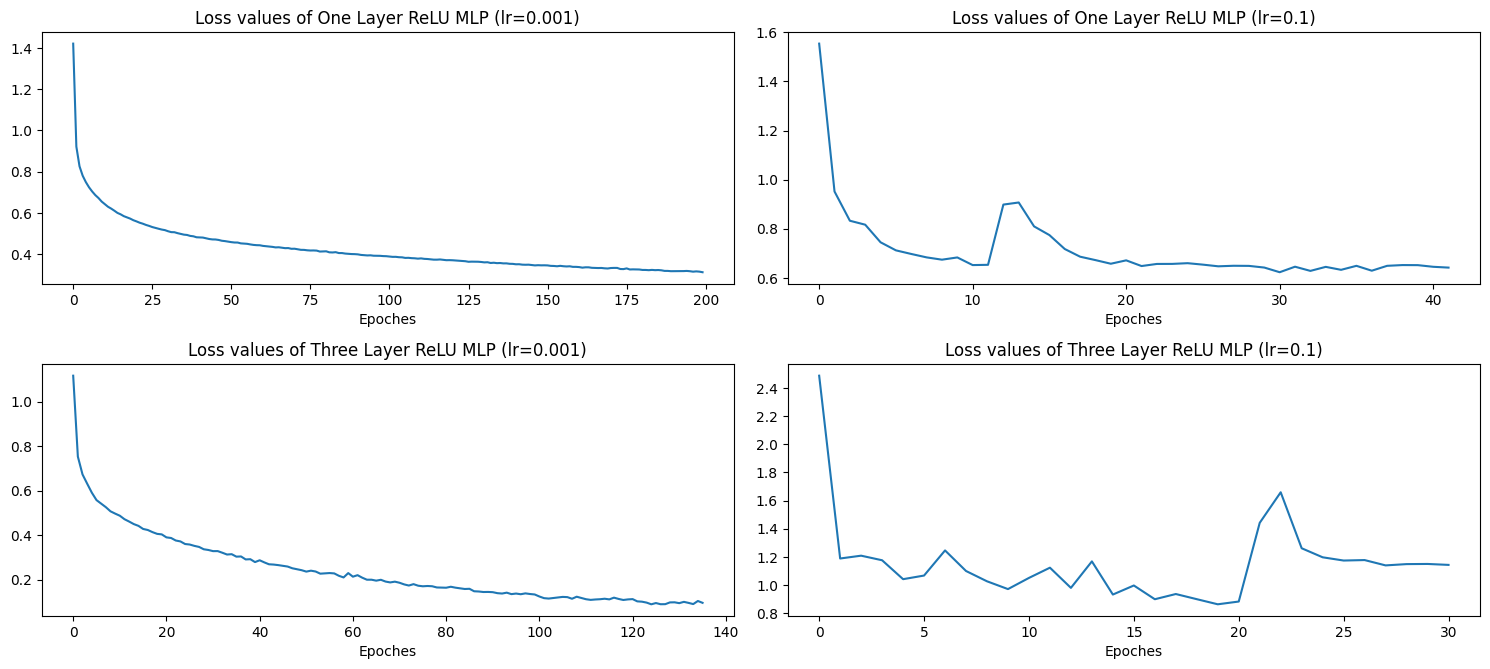

In [ ]:
plt.figure(figsize = (15,13))

MLPs = ["One Layer ReLU MLP (lr=0.001)",
        "One Layer ReLU MLP (lr=0.1)",
        "Three Layer ReLU MLP (lr=0.001)",
        "Three Layer ReLU MLP (lr=0.1)"]

for i in range(4):
    plt.subplot(4, 2, i+1)
    plt.plot(models[MLPs[i]].loss_curve_)
    plt.xlabel("Epoches")
    plt.title(f"Loss values of {MLPs[i]}")
plt.tight_layout()

## Draw a Random Forest Tree

In [ ]:
# from sklearn import tree

# fn = df.columns
# cn = df["Cover_Type"].astype(str).unique()
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
# tree.plot_tree(models["Random Forest Classifier"].estimators_[0],
#                feature_names=fn,
#                class_names=cn,
#                label='none',
#                filled=False);
# fig.savefig('rf_individualtree.png')